***Importing all packages/libraries and datasets***

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fd_14 = pd.read_csv("./Stocks/2014_Financial_Data.csv")
fd_15 = pd.read_csv("./Stocks/2015_Financial_Data.csv")
fd_16 = pd.read_csv("./Stocks/2016_Financial_Data.csv")
fd_17 = pd.read_csv("./Stocks/2017_Financial_Data.csv")
fd_18 = pd.read_csv("./Stocks/2018_Financial_Data.csv")

In [42]:
# print(fd_14.head())
# print(fd_15.head())
# print(fd_16.head())
# print(fd_17.head())
# print(fd_18.head())
fd_14.info()
fd_14.describe()
# print(fd_14[["Unnamed: 0", "Asset Growth", "2015 PRICE VAR [%]", "Class"]])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 225 entries, Unnamed: 0 to Class
dtypes: float64(222), int64(1), object(2)
memory usage: 6.5+ MB


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2015 PRICE VAR [%],Class
count,3.764000e+03,3572.000000,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.745000e+03,3.728000e+03,...,3208.000000,3518.000000,3518.000000,3518.000000,3439.000000,3506.000000,3561.000000,3565.000000,3.808000e+03,3808.000000
mean,5.879050e+09,12.954244,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,1.438144e+09,6.748248e+08,1.002018e+08,5.725866e+08,...,0.036206,4.445793,0.164692,2.279999,0.813931,1.361780,0.596529,0.382284,9.751560e+02,0.429097
std,3.901741e+10,705.605473,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.305171e+09,3.786291e+09,6.991091e+08,2.793740e+09,...,0.259765,161.135098,2.195115,92.428920,25.630214,18.734301,25.894049,4.696975,4.098461e+04,0.495012
min,-6.276160e+08,-1.773200,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-1.088448e+09,-6.786000e+09,-2.250000e+08,-8.878000e+09,...,-1.000000,-1.000000,-1.000000,-0.979600,-230.000000,-1.051000,-1.043700,-1.000000,-1.003972e+02,0.000000
25%,5.788880e+07,-0.002350,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,...,0.000000,-0.045800,0.000000,-0.015400,-0.084550,-0.048200,0.000000,-0.003900,-2.857143e+01,0.000000
50%,4.349010e+08,0.061850,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386610e+08,4.104400e+07,2.563000e+06,2.842700e+07,...,0.000000,0.014250,0.000000,0.062200,0.037100,0.000000,0.000000,0.068800,-5.281842e+00,0.000000
75%,2.393625e+09,0.188875,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,...,0.044000,0.205475,0.063850,0.217100,0.141900,0.210300,0.004700,0.220500,1.331484e+01,1.000000
max,1.824698e+12,42138.663900,1.537249e+12,4.621600e+11,1.153700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,3.605800,9328.200000,76.625000,5468.426400,1360.125000,729.576600,1542.611000,225.690000,2.418601e+06,1.000000


In [43]:
object_cols = list(filter(lambda x: isinstance(fd_14[x][0], str), fd_14.columns))
object_cols

['Unnamed: 0', 'Sector']

['Consumer Defensive' 'Basic Materials' 'Healthcare' 'Consumer Cyclical'
 'Industrials' 'Real Estate' 'Communication Services' 'Energy'
 'Financial Services' 'Utilities' 'Technology']
0    2174
1    1634
Name: Class, dtype: int64


C:\Users\Tanishk\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


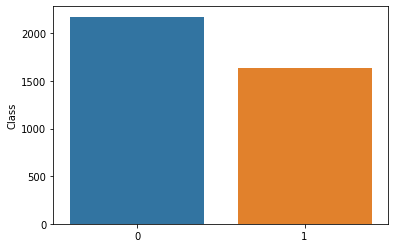

Financial Services        660
Healthcare                582
Technology                576
Industrials               501
Consumer Cyclical         457
Basic Materials           242
Real Estate               224
Energy                    221
Consumer Defensive        165
Utilities                  97
Communication Services     83
Name: Sector, dtype: int64


C:\Users\Tanishk\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


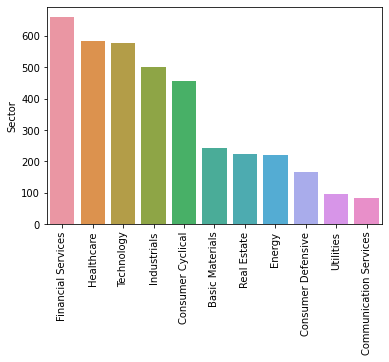

In [54]:
print(fd_14['Sector'].unique())

df_class = fd_14['Class'].value_counts()
print(df_class)
sns.barplot(np.arange(len(df_class)), df_class)
plt.show()


df_sector = fd_14['Sector'].value_counts()
print(df_sector)
sns.barplot(np.arange(len(df_sector)), df_sector)
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.show()

***Attempting to clean data***

In [3]:
# Dropped those columns with more than 50% of their elements as NULL
fd_14 = fd_14.dropna(thresh=len(fd_14)/2, axis=1)
print(fd_14.head())
print(fd_14.shape)

  Unnamed: 0       Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
0         PG  7.440100e+10         -0.0713     3.903000e+10  3.537100e+10   
1       VIPS  3.734148e+09          1.1737     2.805625e+09  9.285226e+08   
2         KR  9.837500e+10          0.0182     7.813800e+10  2.023700e+10   
3        RAD  2.552641e+10          0.0053     1.820268e+10  7.323734e+09   
4        GIS  1.790960e+10          0.0076     1.153980e+10  6.369800e+09   

   R&D Expenses  SG&A Expense  Operating Expenses  Operating Income  \
0  0.000000e+00  2.146100e+10        2.146100e+10      1.391000e+10   
1  1.083303e+08  3.441414e+08        7.939267e+08      1.345959e+08   
2  0.000000e+00  1.519600e+10        1.751200e+10      2.725000e+09   
3  0.000000e+00  6.561162e+09        6.586482e+09      7.372520e+08   
4  0.000000e+00  3.474300e+09        3.412400e+09      2.957400e+09   

   Interest Expense  ...  Receivables growth  Inventory Growth  Asset Growth  \
0      7.090000e+08  ...      

In [4]:

fd_14.isnull().sum()

Unnamed: 0                0
Revenue                  44
Revenue Growth          236
Cost of Revenue          74
Gross Profit             52
                       ... 
R&D Expense Growth      247
SG&A Expenses Growth    243
Sector                    0
2015 PRICE VAR [%]        0
Class                     0
Length: 222, dtype: int64

In [5]:
# Test to see how many rows will be left if all NULL valued rows were removed
# print(fd_14.dropna().shape)

**THIS IS NOT GOOD AS WE LOST A LOT OF DATA**

In [6]:
testGrowth = list(map(lambda x: 1 if not np.isnan(x) else 0, fd_14["Revenue Growth"]))
fd_14["testGrowth"] = testGrowth


In [17]:
test14 = fd_14[(fd_14.testGrowth == 0)] ## Null values
test14[['Class', 'testGrowth']]
print(test14.groupby('Class')['Class'].count())

test14 = fd_14[(fd_14.testGrowth == 1)] ## Non Null values
test14[['Class', 'testGrowth']]
print(test14.groupby('Class')['Class'].count())

Class
0    114
1    122
Name: Class, dtype: int64
Class
0    2060
1    1512
Name: Class, dtype: int64


**Looking at relationships between some variables**

In [6]:
# print(fd_14["Revenue"])
fd_14["Revenue"] = fd_14["Revenue"].fillna(0.0) 
# fd_14["Revenue Growth"] = fd_14["Revenue Growth"].fillna(fd_14["Revenue Growth"].mean())

In [13]:
# fig = plt.figure()


# plt.bar(x=fd_14['Class'], y = fd_14["testGrowth"])
# plt.xlabel("Revenue Growth")
# plt.ylabel("Should I buy it or not")
# plt.hist()
# plt.show()
test14['Class'].value_counts()

1    122
0    114
Name: Class, dtype: int64

In [11]:
# col = list(fd_14.columns)
# rev = list(filter(lambda a: "revenue" in a or "Revenue" in a, col))
# print(rev)
# expenses = list(filter(lambda a: "expense" in a or "Expense" in a, col))
# print(expenses)
print(fd_14["Revenue Growth"].mean())
print(fd_14["Revenue Growth"])

12.95424370100784
0      -0.0713
1       1.1737
2       0.0182
3       0.0053
4       0.0076
         ...  
3803    0.1028
3804   -0.1019
3805       NaN
3806    0.1344
3807    0.1925
Name: Revenue Growth, Length: 3808, dtype: float64
